In [1]:
import numpy as np
import xarray as xr
import scipy.ndimage as ndimage
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from datetime import datetime

In [2]:
# Get dataset from NOMADS Server
ds = xr.open_dataset('http://nomads.ncep.noaa.gov:80/dods/gfs_0p25_1hr/gfs20201127/gfs_0p25_1hr_18z')

# Select desired vars
ds = ds[['hgtprs', 'tmpprs', 'ugrdprs', 'vgrdprs', 'rhprs']]

# Select time
ds = ds.sel(time=ds.time[0])

# Select level
ds = ds.sel(lev=slice(925, 850))

# Select lat/lon slice
ds = ds.sel(lon=slice(220, 310), lat=slice(15, 65))

# Get mean over levels
ds = ds.mean(dim=['lev'])

ds

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 361)
Coordinates:
  * lat      (lat) float64 15.0 15.25 15.5 15.75 16.0 ... 64.25 64.5 64.75 65.0
  * lon      (lon) float64 220.0 220.2 220.5 220.8 ... 309.2 309.5 309.8 310.0
    time     datetime64[ns] 2020-11-27T18:00:00
Data variables:
    hgtprs   (lat, lon) float32 1124.5703 1125.9623 ... 905.8343 907.42365
    tmpprs   (lat, lon) float32 290.7861 290.61942 ... 261.21945 260.9861
    ugrdprs  (lat, lon) float32 -8.996081 -8.679415 ... -1.6060815 -2.0627482
    vgrdprs  (lat, lon) float32 0.4614884 0.51148844 ... 5.264822 6.058155
    rhprs    (lat, lon) float32 73.6 74.299995 74.26667 ... 95.166664 95.700005

In [3]:
# Set calculation units 
T, u, v = ds.tmpprs.values * units('K'), ds.ugrdprs.values * units('m/s'), ds.vgrdprs.values * units('m/s')

# Smooth data
z = ndimage.gaussian_filter(ds.hgtprs, sigma=3, order=0)

# Set plot units
u = u.to('kt')
v = v.to('kt')
T = T.to('degC')

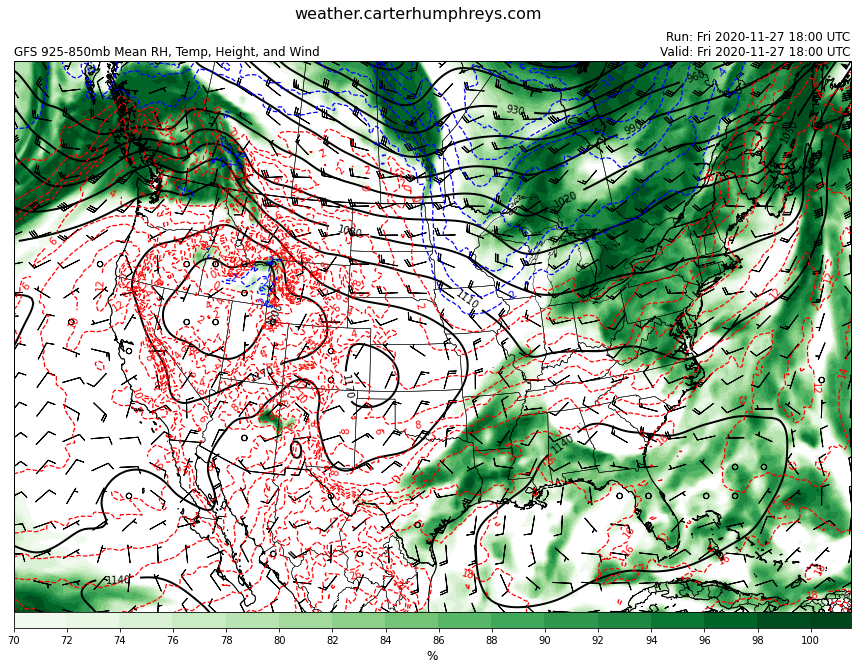

In [4]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Create new figure
fig = plt.figure(figsize=(15, 12.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99, hspace=0.01, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=plotcrs)
ax.set_extent([235, 290, 20, 55])

# Add state/country boundaries to plot
country_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='10m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1.0)
state_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
ax.add_feature(state_borders, edgecolor='black', linewidth=0.5)

# Plot Height Contours
clev = np.arange(0, 8000, 30)
cs = ax.contour(ds.lon, ds.lat, z, clev, colors='black', linewidths=2, transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours (<0)
clev = np.arange(-40, 0, 2)
cs2 = ax.contour(ds.lon, ds.lat, T, clev, colors='blue', linewidths=1.25, linestyles='--', transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours (>=0)
clev = np.arange(0, 41, 2)
cs2 = ax.contour(ds.lon, ds.lat, T, clev, colors='red', linewidths=1.25, linestyles='--', transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Colorfill of RH
cint = np.arange(70, 101, 2)
cf = ax.contourf(ds.lon, ds.lat, ds.rhprs, cint[cint != 0], extend='max', cmap='Greens', transform=datacrs)
cb = plt.colorbar(cf, ax=ax, pad=0, aspect=50, orientation='horizontal', extendrect=True, ticks=cint)
cb.set_label('%', size='large')

# Plot Wind Barbs
ax.barbs(ds.lon, ds.lat, u.magnitude, v.magnitude, length=6, regrid_shape=20, pivot='middle', transform=datacrs)

# Change datetiem64 to datetime
valid = datetime.utcfromtimestamp(ds.time.values.astype('O')/1e9)

# Add plot headers
plt.title(f'GFS 925-850mb Mean RH, Temp, Height, and Wind', loc='left')
plt.title(f'Run: {valid.strftime("%a %Y-%m-%d %H:%M")} UTC\nValid: {valid.strftime("%a %Y-%m-%d %H:%M")} UTC', loc='right')

# Add title
plt.suptitle(f'weather.carterhumphreys.com', fontsize=16, x=0.50, y=0.90)
    
# Export plot and close
plt.show()